# Set up the rdkit env + functions

In [1]:
#should be 3.7.10
!python --version

Python 3.7.10


In [2]:
#run rdkit installer

import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
rdkit is already installed


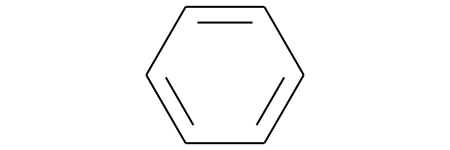

In [3]:
#if everything works, you'll see benzene (six carbon atoms joined in a planar ring with one hydrogen atom attached to each)

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

Chem.MolFromSmiles('c1ccccc1')

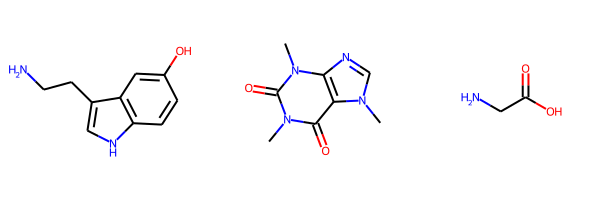

In [4]:
#let us draw the following molecules:
#serotonin https://en.wikipedia.org/wiki/Serotonin
#caffeine https://en.wikipedia.org/wiki/Caffeine
#glycine https://en.wikipedia.org/wiki/Glycine
#we copy their smiles into a list:
smiles_list = ['C1=CC2=C(C=C1O)C(=CN2)CCN', 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'C(C(=O)O)N']
#import Draw
from rdkit.Chem import Draw

mol_list = []
for smiles in smiles_list:
	mol = Chem.MolFromSmiles(smiles)
	mol_list.append(mol)

img = Draw.MolsToGridImage(mol_list, molsPerRow=len(mol_list))
img

In [5]:
#we'll need mordred for descriptors
!pip install mordred

In [6]:
from rdkit import Chem
from rdkit.Chem import rdchem
#from rdkit.Chem import AllChem
from tqdm.notebook import tqdm
import re

# xp = np

#
Chiral = {"CHI_UNSPECIFIED":0,  "CHI_TETRAHEDRAL_CW":1, "CHI_TETRAHEDRAL_CCW":2, "CHI_OTHER":3}
Hybridization = {"UNSPECIFIED":0, "S":1, "SP":2, "SP2":3, "SP3":4, "SP3D":5, "SP3D2":6, "OTHER":7}

 # featurevector
atomInfo = 21
structInfo = 21
lensize= atomInfo + structInfo

H_Vector = [0]*atomInfo
H_Vector[0]= 1

#
lowerReg = re.compile(r'^[a-z]+$')
def islower(s):
    return lowerReg.match(s) is not None

#
upperReg = re.compile(r'^[A-Z]+$')
def isupper(s):
    return upperReg.match(s) is not None

#
def calc_atom_feature(atom):
    
    if atom.GetSymbol() == 'H':   feature = [1,0,0,0,0]
    elif atom.GetSymbol() == 'C': feature = [0,1,0,0,0]
    elif atom.GetSymbol() == 'O': feature = [0,0,1,0,0]
    elif atom.GetSymbol() == 'N': feature = [0,0,0,1,0]
    else: feature = [0,0,0,0,1]
        
    feature.append(atom.GetTotalNumHs()/8)
    feature.append(atom.GetTotalDegree()/4)
    feature.append(atom.GetFormalCharge()/8)
    feature.append(atom.GetTotalValence()/8)
    feature.append(atom.IsInRing()*1)
    feature.append(atom.GetIsAromatic()*1)

    f =  [0]*(len(Chiral)-1)
    if Chiral.get(str(atom.GetChiralTag()), 0) != 0:
        f[Chiral.get(str(atom.GetChiralTag()), 0)] = 1
    feature.extend(f)

    f =  [0]*(len(Hybridization)-1)
    if Hybridization.get(str(atom.GetHybridization()), 0) != 0:
        f[Hybridization.get(str(atom.GetHybridization()), 0)] = 1
    feature.extend(f)
    
    return(feature)


def calc_structure_feature(c,flag,label):
    feature = [0]*structInfo

    if c== '(' :
        feature[0] = 1
        flag = 0
    elif c== ')' :
        feature[1] = 1
        flag = 0
    elif c== '[' :
        feature[2] = 1
        flag = 0
    elif c== ']' :
        feature[3] = 1
        flag = 0
    elif c== '.' :
        feature[4] = 1
        flag = 0
    elif c== ':' :
        feature[5] = 1
        flag = 0
    elif c== '=' :
        feature[6] = 1
        flag = 0
    elif c== '#' :
        feature[7] = 1
        flag = 0
    elif c== '\\':
        feature[8] = 1
        flag = 0
    elif c== '/' :
        feature[9] = 1
        flag = 0  
    elif c== '@' :
        feature[10] = 1
        flag = 0
    elif c== '+' :
        feature[11] = 1
        flag = 1
    elif c== '-' :
        feature[12] = 1
        flag = 1
    elif c.isdigit() == True:
        if flag == 0:
            if c in label:
                feature[20] = 1
            else:
                label.append(c)
                feature[19] = 1
        else:
            feature[int(c)-1+12] = 1
            flag = 0
    return(feature,flag,label)


def calc_featurevector(mol, smiles,atomsize):
    flag = 0
    label = []
    molfeature=[]
    idx = 0
    j = 0
            
    for c in smiles:
        if islower(c) == True: continue
        elif isupper(c) == True:
            if c == 'H':
                molfeature.extend(H_Vector)
            else:
                molfeature.extend(calc_atom_feature(rdchem.Mol.GetAtomWithIdx(mol, idx)))
                idx = idx + 1
            molfeature.extend([0]*structInfo)
            j = j +1
            
        else:   
            molfeature.extend([0]*atomInfo)
            f,flag,label = calc_structure_feature(c,flag,label)
            molfeature.extend(f)
            j = j +1

    #0-Padding
    molfeature.extend([0]*(atomsize-j)*lensize)        
    return(molfeature)


def mol_to_feature(mol,n,atomsize):
    try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(n))
    except: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True)
    try: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(n))
    except: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)
    return calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES,atomsize)

def mol_to_allSMILESfeature(mol, atomsize):
    idx, features =0,  []
    while idx < mol.GetNumAtoms():
        try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(idx))
        except: break
        isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(idx))
        features.append(calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES,atomsize))
        idx = idx + 1
    return(features)


def atom_flag(smiles,atomsize):
    flag=[]
    j = 0
            
    for c in smiles:
        if islower(c) == True: 
            if c in ['c', 'n', 's', 'o']:
                flag.append(1)
            else:
                flag.append(0)
        elif isupper(c) == True:
            if c in ['H',]:
                flag.append(0)
            else:
                flag.append(1)
        else:   
            flag.append(0)           

    #0-Padding
    flag.extend([0]*(atomsize-len(smiles)))        
    return(flag)

# Grab SMILES from the DB

In [7]:
#Get ViralChEMBL_dataset
#https://drive.google.com/file/d/1elBvTVU4ofqdCtyhxj1qHH9hyZw2oYtu/view?usp=sharing
!gdown --id "1elBvTVU4ofqdCtyhxj1qHH9hyZw2oYtu"

!unzip -q ViralChEMBL_dataset.zip && rm ViralChEMBL_dataset.zip

import pandas as pd

vChEMBL = pd.read_csv('/content/ViralChEMBL_dataset.csv')

Downloading...
From: https://drive.google.com/uc?id=1elBvTVU4ofqdCtyhxj1qHH9hyZw2oYtu
To: /content/ViralChEMBL_dataset.zip
22.0MB [00:00, 103MB/s] 
replace ViralChEMBL_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
#Get pathogens
#https://drive.google.com/file/d/13ptmYrB0H-vPcFV-QQGmNKrUnjCGNIYE/view?usp=sharing
!gdown --id "13ptmYrB0H-vPcFV-QQGmNKrUnjCGNIYE"

pathogens = pd.read_csv('/content/PathogenList.csv')

Downloading...
From: https://drive.google.com/uc?id=13ptmYrB0H-vPcFV-QQGmNKrUnjCGNIYE
To: /content/PathogenList.csv
100% 16.2k/16.2k [00:00<00:00, 12.6MB/s]


In [9]:
import pandas as pd

vChEMBL = pd.read_csv('/content/ViralChEMBL_dataset.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
pathogens = pd.read_csv('/content/PathogenList.csv')

In [11]:
pathogens = pathogens[pathogens['species_name']!='Unassigned']

In [12]:
pathogens

,species_id,species_name,genus_id,path_flag
0,480,Human herpesvirus 1,1882,1
1,481,Human herpesvirus 2,1882,1
2,483,Macacine herpesvirus 1,1882,1
3,487,Saimiriine herpesvirus 1,1882,4
4,503,Human herpesvirus 3,1884,1
...,...,...,...,...
465,2989,Venezuelan equine encephalitis virus,2279,1
466,2990,Western equine encephalitis virus,2279,1
467,2991,Whataroa virus,2279,1
468,2992,Rubella virus,2280,1


In [13]:
##calculate pathogens_intersections

# from itertools import combinations
# from tqdm.notebook import tqdm

# id1 = []
# id2 = []
# intersec = []
# len_id1 = []
# len_id2 = []

# for combi in tqdm(combinations(pathogens.species_id.to_list(), 2)):
#   id1.append(combi[0])
#   id2.append(combi[1])
#   len_id1.append(len(vChEMBL[vChEMBL['species_id']==combi[0]]['canonical_smiles'].unique()))
#   len_id2.append(len(vChEMBL[vChEMBL['species_id']==combi[1]]['canonical_smiles'].unique()))
#   intersec.append(len(set(vChEMBL[vChEMBL['species_id']==combi[0]]['canonical_smiles']).intersection(vChEMBL[vChEMBL['species_id']==combi[1]]['canonical_smiles'])))

# intersections = pd.DataFrame()

# intersections['id1'] = id1
# intersections['id2'] = id2
# intersections['intersec'] = intersec
# intersections['len_id1'] = len_id1
# intersections['len_id2'] = len_id2

# intersections.sort_values(by='intersec').to_csv('pathogens_intersections.csv', index = False)

In [14]:
#get pathogens_intersections
#https://drive.google.com/file/d/1OeL7dckDJXgQ8YiPbwkxAJ2yqVwwS9WV/view?usp=sharing
!gdown --id "1OeL7dckDJXgQ8YiPbwkxAJ2yqVwwS9WV"

intersections = pd.read_csv('/content/pathogens_intersections.csv')

Downloading...
From: https://drive.google.com/uc?id=1OeL7dckDJXgQ8YiPbwkxAJ2yqVwwS9WV
To: /content/pathogens_intersections.csv
100% 1.79M/1.79M [00:00<00:00, 46.9MB/s]


In [15]:
intersections['tot'] = intersections['len_id1']+intersections['len_id2']

In [16]:
intersections[(intersections['len_id1']>300) & (intersections['len_id2']>300) & (intersections['intersec']==0)]

,id1,id2,intersec,len_id1,len_id2,tot
3462,1188,2941,0,63687,345,64032
35487,2486,2941,0,1512,345,1857
35515,2486,2983,0,1512,514,2026
36050,2941,2983,0,345,514,859
37386,2891,2941,0,1338,345,1683
37860,1624,2486,0,1073,1512,2585
38983,1615,2486,0,893,1512,2405
68496,527,772,0,1063,899,1962
68498,527,771,0,1063,824,1887
76279,602,2941,0,407,345,752


In [17]:
#771,Rhinovirus A
#1969,Hepatitis B virus

In [18]:
id1 = 771
id2 = 1969

In [19]:
len(vChEMBL[vChEMBL['species_id']==id1]['canonical_smiles'].unique())

824

In [20]:
len(vChEMBL[vChEMBL['species_id']==id2]['canonical_smiles'].unique())

2011

In [21]:
len(set(vChEMBL[vChEMBL['species_id']==id1]['canonical_smiles']).intersection(vChEMBL[vChEMBL['species_id']==id2]['canonical_smiles']))

0

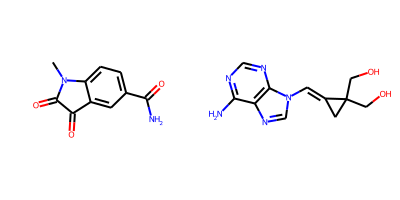

In [22]:
smiles_list = [vChEMBL[vChEMBL['species_id']==id1][:1]['std_smiles'].item(), vChEMBL[vChEMBL['species_id']==id2][:1]['canonical_smiles'].item()]
mol_list = []
for smiles in smiles_list:
	mol = Chem.MolFromSmiles(smiles)
	mol_list.append(mol)

img = Draw.MolsToGridImage(mol_list, molsPerRow=len(mol_list))
img

In [23]:
dataset = pd.DataFrame()
dataset['smiles'] = vChEMBL[(vChEMBL['species_id']==id1)|(vChEMBL['species_id']==id2)]['canonical_smiles'].to_list()
dataset['active'] = vChEMBL[(vChEMBL['species_id']==id1)|(vChEMBL['species_id']==id2)]['species_id'].to_list()

dataset['active'] = dataset['active'].replace(id1,0)
dataset['active'] = dataset['active'].replace(id2,1)
dataset

,smiles,active
0,Nc1ncnc2c1ncn2\C=C\3/CC3(CO)CO,1.0
1,Nc1nc(NC2CC2)c3ncn(\C=C/4\CC4(CO)CO)c3n1,1.0
2,NC1=Nc2c(ncn2\C=C/3\CC3(CO)CO)C(=O)N1,1.0
3,Nc1nc(F)c2ncn(\C=C\3/CC3(CO)CO)c2n1,1.0
4,Nc1nc(Cl)c2ncn(\C=C\3/CC3(CO)CO)c2n1,1.0
...,...,...
8193,O=C1N=CC=C2N(C=CN12)[C@@H]3O[C@H](COCc4ccccc4)...,0.0
8194,NC1=NC(=O)N2C=CN([C@@H]3O[C@H](COCc4ccccc4)[C@...,0.0
8195,OC[C@H]1O[C@H]([C@@H](O)[C@@H]1O)N2C=CN3C(=O)N...,0.0
8196,NC1=NC(=O)N2C=CN([C@@H]3O[C@H](CO)[C@@H](O)[C@...,0.0


# Dataset --> input features (json)

In [24]:
from rdkit import Chem
import numpy as np
import pickle
from mordred import Calculator, descriptors

#MAX_LEN = 150
#INPUT_SMILES = 'egfr.csv'
#OUTPUT = 'egfr.pickle'
SMILE = 'smiles'
ACTIVE = 'active'
ID = 'id'
DEBUG = False

In [25]:
df = dataset
print(df.head())
print ('Shape before dropping duplicates: ', df.shape)
df = df.drop_duplicates(subset=[SMILE])
print ('Shape after dropping duplicates: ', df.shape)

                                     smiles  active
0            Nc1ncnc2c1ncn2\C=C\3/CC3(CO)CO     1.0
1  Nc1nc(NC2CC2)c3ncn(\C=C/4\CC4(CO)CO)c3n1     1.0
2     NC1=Nc2c(ncn2\C=C/3\CC3(CO)CO)C(=O)N1     1.0
3       Nc1nc(F)c2ncn(\C=C\3/CC3(CO)CO)c2n1     1.0
4      Nc1nc(Cl)c2ncn(\C=C\3/CC3(CO)CO)c2n1     1.0
Shape before dropping duplicates:  (8198, 2)
Shape after dropping duplicates:  (2835, 2)


In [26]:
MAX_LEN = df['smiles'].map(lambda x: len(str(x))).max()

In [27]:
mols = [Chem.MolFromSmiles(i) for i in df.smiles]
calc = Calculator(descriptors, ignore_3D=True)
#md = calc.pandas(mols)

In [28]:
md = calc.pandas(mols)

  3%|▎         | 95/2835 [00:45<24:33,  1.86it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 21%|██▏       | 604/2835 [04:55<26:33,  1.40it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 2835/2835 [33:29<00:00,  1.41it/s]


In [29]:
smile_ft = [mol_to_feature(mol,-1, MAX_LEN) for mol in mols]

In [30]:
md['active'] = df.active
md['smile'] = df.smiles
md['smile_ft'] = smile_ft

#md.head()
md

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,...,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,active,smile,smile_ft
0,14.068596,13.228191,0,0,23.5481,2.55503,4.85636,23.5481,1.30823,3.88342,3.54182,0.196768,1.85243,127.688,7.09381,5.43738,9,10,31,18,0,0,7,13,0,11,5,2,0,0,0,0,0,0,0,278.000000,279.000000,393.0,392.000000,297.000000,...,0.000000,0.547368,9,5,0.800000,0.444444,199.325,5.321928,20.0,4.615121,5.517453,6.440947,7.362011,8.290794,9.217415,10.147962,11.077192,12.008761,112.677655,3.713572,1.945910,5.081404,4.262680,6.673298,6.378426,8.361942,8.385032,10.099095,72.901360,247.106925,7.971191,613,27,100.0,124.0,5.86806,4.041667,1.0,Nc1ncnc2c1ncn2\C=C\3/CC3(CO)CO,"[0, 0, 0, 1, 0, 0.25, 0.75, 0.0, 0.375, 0, 0, ..."
1,17.604129,15.650823,0,0,29.0444,2.56101,4.9187,29.0444,1.3202,4.11136,3.89608,0.177094,2.14843,195.273,8.87605,6.06286,9,10,40,22,0,0,8,18,0,14,6,2,0,0,0,0,0,0,0,318.000000,333.000000,468.0,484.000000,435.000000,...,0.006667,0.534073,11,6,0.833333,0.454545,249.853,5.643856,25.0,4.844187,5.746203,6.675823,7.596392,8.529319,9.455871,10.389764,11.319256,12.253810,123.810627,3.931826,2.564949,5.313206,4.709530,6.900731,6.700731,8.581294,8.629271,10.311649,79.643187,302.149124,7.553728,1070,33,126.0,156.0,6.59028,4.791667,1.0,Nc1nc(NC2CC2)c3ncn(\C=C/4\CC4(CO)CO)c3n1,"[0, 0, 0, 1, 0, 0.25, 0.75, 0.0, 0.375, 0, 0, ..."
2,14.885092,13.956041,0,0,24.333,2.55768,4.89518,24.333,1.28068,3.93346,3.65533,0.192386,1.93804,133.374,7.01966,5.53501,9,10,32,19,0,0,8,13,0,11,5,3,0,0,0,0,0,0,0,312.000000,305.000000,440.0,458.000000,384.000000,...,0.000000,0.590749,9,5,0.800000,0.444444,208.115,5.392317,21.0,4.672829,5.572154,6.502790,7.422374,8.356320,9.282382,10.217020,11.146186,12.081195,115.253249,3.761200,1.945910,5.141664,4.262680,6.734592,6.378426,8.423981,8.385032,10.163657,74.197142,263.101839,8.221932,705,29,106.0,131.0,6.72917,4.208333,1.0,NC1=Nc2c(ncn2\C=C/3\CC3(CO)CO)C(=O)N1,"[0, 0, 0, 1, 0, 0.25, 0.75, 0.0, 0.375, 0, 0, ..."
3,14.885092,13.956041,0,0,24.333,2.55768,4.89518,24.333,1.28068,3.93346,3.65533,0.192386,1.93804,133.374,7.01966,5.53501,9,10,31,19,0,0,8,12,0,11,5,2,0,0,1,0,0,0,1,334.000000,317.000000,467.0,480.000000,408.000000,...,0.000000,0.590749,9,5,0.800000,0.444444,205.392,5.392317,21.0,4.672829,5.572154,6.502790,7.422374,8.356320,9.282382,10.217020,11.146186,12.081195,115.253249,3.761200,1.945910,5.141664,4.262680,6.734592,6.378426,8.423981,8.385032,10.163657,74.197142,265.097503,8.551532,705,29,106.0,131.0,6.72917,4.208333,1.0,Nc1nc(F)c2ncn(\C=C\3/CC3(CO)CO)c2n1,"[0, 0, 0, 1, 0, 0.25, 0.75, 0.0, 0.375, 0, 0, ..."
4,14.885092,13.956041,0,0,24.333,2.55768,4.89518,24.333,1.28068,3.93346,3.65533,0.192386,1.93804,133.374,7.01966,5.53501,9,10,31,19,0,0,8,12,0,11,5,2,0,0,0,1,0,0,1,285.604938,292.111111,411.0,399.111111,308.444444,...,0.000000,0.590749,9,5,0.800000,0.444444,214.536,5.392317,21.0,4.672829,5.572154,6.502790,7.422374,8.356320,9.282382,10.217020,11.146186,12.081195,115.253249,3.761200,1.945910,5.141664,4.262680,6.734592,6.378426,8.423981,8.385032,10.163657,74.197142,281.067952,9.066708,705,29,106.0,131.0,6.72917,4.208333,1.0,Nc1nc(Cl)c2ncn(\C=C\3/CC3(CO)CO)c2n1,"[0, 0, 0, 1, 0, 0.25, 0.75, 0.0, 0.375, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,31.646114,23.091300,0,0,53.9788,2.53069,4.87968,53.9788,1.34947,

In [31]:
md.to_csv('/content/771vs1969_10_full_ft_pd_lines.csv')

In [32]:
test = pd.read_csv('/content/771vs1969_10_full_ft_pd_lines.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (140,141,142,143,149,150,151,152,167,168,169,170,176,177,178,179,185,186,187,188,194,195,196,197,203,204,205,206,212,213,214,215,221,222,223,224,230,231,232,233,234,235,236,237,238,239,240,241,242,342,343,344,345,346,347,348,349,350,356,357,358,359,365,366,367,368,383,384,385,386,392,393,394,395,401,402,403,404,410,411,412,413,419,420,421,422,428,429,430,431,437,438,439,440,446,447,448,449,450,451,452,453,454,455,456,457,462,463,464,465,470,471,472,473,486,487,488,489,494,495,496,497,502,503,504,505,510,511,512,513,518,519,520,521,526,527,528,529,534,535,536,537,542,543,544,545,546,547,548,549,550,551,552,553,558,559,560,561,566,567,568,569,582,583,584,585,590,591,592,593,598,599,600,601,606,607,608,609,614,615,616,617,622,623,624,625,630,631,632,633,638,639,640,641,781,782,829,830,831,832,833,834,842,845,846,847,848,849,1302,1364,1365,1367) have mixed types.Specify dtype option on impor

In [33]:
test.dropna()

,Unnamed: 0,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,...,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,active,smile,smile_ft
0,0,14.068596,13.228191,0,0,23.548102696767515,2.5550258390422638,4.856358801294739,23.548102696767515,1.3082279275981952,3.8834162068573352,3.5418173174029315,0.1967676287446073,1.8524266268183058,127.68849375868884,7.093805208816047,5.437380320190263,9,10,31,18,0,0,7,13,0,11,5,2,0,0,0,0,0,0,0,278.000000,279.000000,393.000000,392.000000,...,0.000000,0.547368,9,5,0.800000,0.444444,199.32488171981794,5.321928,20.0,4.615121,5.517453,6.440947,7.362011,8.290794,9.217415,10.147962,11.077192,12.008761,112.677655,3.713572,1.945910,5.081404,4.262680,6.673298,6.378426,8.361942,8.385032,10.099095,72.901360,247.106925,7.971191,613,27,100.0,124.0,5.868055555555555,4.041667,1.0,Nc1ncnc2c1ncn2\C=C\3/CC3(CO)CO,"[0, 0, 0, 1, 0, 0.25, 0.75, 0.0, 0.375, 0, 0, ..."
1,1,17.604129,15.650823,0,0,29.044362707097818,2.561013623430655,4.918696671184004,29.044362707097818,1.3201983048680825,4.111356854686748,3.896075900466929,0.17709435911213314,2.1484272275941496,195.27306776898865,8.87604853495403,6.0628562868890725,9,10,40,22,0,0,8,18,0,14,6,2,0,0,0,0,0,0,0,318.000000,333.000000,468.000000,484.000000,...,0.006667,0.534073,11,6,0.833333,0.454545,249.85313904136794,5.643856,25.0,4.844187,5.746203,6.675823,7.596392,8.529319,9.455871,10.389764,11.319256,12.253810,123.810627,3.931826,2.564949,5.313206,4.709530,6.900731,6.700731,8.581294,8.629271,10.311649,79.643187,302.149124,7.553728,1070,33,126.0,156.0,6.590277777777778,4.791667,1.0,Nc1nc(NC2CC2)c3ncn(\C=C/4\CC4(CO)CO)c3n1,"[0, 0, 0, 1, 0, 0.25, 0.75, 0.0, 0.375, 0, 0, ..."
2,2,14.885092,13.956041,0,0,24.33301336646524,2.557679932436325,4.895176360460734,24.33301336646524,1.2806849140244865,3.933457667492678,3.655327243498992,0.19238564439468378,1.9380395084713467,133.37362260716222,7.01966434774538,5.535008268521959,9,10,32,19,0,0,8,13,0,11,5,3,0,0,0,0,0,0,0,312.000000,305.000000,440.000000,458.000000,...,0.000000,0.590749,9,5,0.800000,0.444444,208.11510867130846,5.392317,21.0,4.672829,5.572154,6.502790,7.422374,8.356320,9.282382,10.217020,11.146186,12.081195,115.253249,3.761200,1.945910,5.141664,4.262680,6.734592,6.378426,8.423981,8.385032,10.163657,74.197142,263.101839,8.221932,705,29,106.0,131.0,6.729166666666666,4.208333,1.0,NC1=Nc2c(ncn2\C=C/3\CC3(CO)CO)C(=O)N1,"[0, 0, 0, 1, 0, 0.25, 0.75, 0.0, 0.375, 0, 0, ..."
3,3,14.885092,13.956041,0,0,24.33301336646524,2.5576799324363235,4.895176360460731,24.33301336646524,1.2806849140244865,3.933457667492678,3.655327243499008,0.1923856443946846,1.938039508471351,133.37362260716,7.019664347745263,5.535008268521942,9,10,31,19,0,0,8,12,0,11,5,2,0,0,1,0,0,0,1,334.000000,317.000000,467.000000,480.000000,...,0.000000,0.590749,9,5,0.800000,0.444444,205.3924406736258,5.392317,21.0,4.672829,5.572154,6.502790,7.422374,8.356320,9.282382,10.217020,11.146186,12.081195,115.253249,3.761200,1.945910,5.141664,4.262680,6.734592,6.378426,8.423981,8.385032,10.163657,74.197142,265.097503,8.551532,705,29,106.0,131.0,6.729166666666666,4.208333,1.0,Nc1nc(F)c2ncn(\C=C\3/CC3(CO)CO)c2n1,"[0, 0, 0, 1, 0, 0.25, 0.75, 0.0, 0.375, 0, 0, ..."
4,4,14.885092,13.956041,0,0,24.33301336646524,2.5576799324363235,4.895176360460731,24.33301336646524,1.2806849140244865,3.933457667492678,3.655327243499008,0.1923856443946846,1.938039508471351,133.37362260716,7.019664347745263,5.535008268521942,9,10,31,19,0,0,8,12,0,11,5,2,0,0,0,1,0,0,1,285.604938,292.111111,411.000000,399.111111,...,0.000000,0.590749,9,5,0.800000,0.444444,214.53594974972418,5.392317,21.0,4.672829,5.572154,6.502790,7.4

In [36]:
import json
json.dump(test.to_json(), open('/content/descriptors.json', 'w'))

In [34]:
## import json
## with open('/content/patients.json', 'w') as f:
##     json.dump(patients, f)